# Summary of Findings
1. **One note for the modelling process**: <br>When using weather data, we can't attain real data of tomorrow so only forecasted weather for tomorrow or historical weather could be used in forecasting or modelling!
2. **Temperature**: Highly correlated with nbr of rides (82%). In 2020, temperature and rides seem less close compared to 2021 onwards, which is highly possible to be caused by covid.
3. **Rain**: Correlation between rides and Rain is small (-7.34%) and means of rides are not statistically different between rainy days and non-rainy days.
4. **Snow**: Correlation between rides and Snow is -26.41% and means of rides are statistically different between snowy days and non-snowy days.
5. **Wind**: Correlation between rides and Wind is -28.42%.
6. **Real Values vs Forecasted Values**: Forecasted temperature and snow are accurate, with R2 of 98.5% and 81.7%, while wind is not forecasted correctly, with a 33.5 R2.
7. **Relations between weather**: The Temperature's correlations between rain, snow wind are 0.21, -0.24, and -0.19.

# Preparations

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
import json
import zipfile
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")


In [ ]:
# Step 1: Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [ ]:
def plot_ts(time_data,plot_data,title_ts=""):
  fig, ax = plt.subplots(figsize=(20, 5))

  # Plot the data
  ax.plot(time_data,plot_data)

  # Set the primary x-axis for months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

  # Add the secondary x-axis for years in the middle of the year
  sec_ax = ax.secondary_xaxis("bottom")
  sec_ax.xaxis.set_major_locator(mdates.YearLocator())
  sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  sec_ax.tick_params(axis='x', which='major', pad=20)

  # Labeling and title
  ax.set_ylabel('Number of Rides')
  ax.set_title(title_ts)
  sec_ax.set_xlabel('Time')

  # Display the grid and the plot
  ax.grid(True)
  plt.show()

def compare_ts(time_data, series1, series2, label1, label2, title_ts=""):
    fig, ax1 = plt.subplots(figsize=(20, 5))

    # Plot series1 on the left y-axis
    line1, = ax1.plot(time_data, series1, color='blue', label=label1)
    ax1.set_ylabel(label1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Set the primary x-axis for months
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

    # Add the secondary x-axis for years
    sec_ax = ax1.secondary_xaxis("bottom")
    sec_ax.xaxis.set_major_locator(mdates.YearLocator())
    sec_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sec_ax.tick_params(axis='x', which='major', pad=20)
    sec_ax.set_xlabel('Time')

    # Create a twin axis for the right y-axis
    ax2 = ax1.twinx()
    line2, = ax2.plot(time_data, series2, color='orange', label=label2)
    ax2.set_ylabel(label2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Set title and grid
    ax1.set_title(title_ts)
    ax1.grid(True)

    # Combine legends for both plots
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc="upper left")

    # Adjust layout
    fig.tight_layout()
    plt.show()

def error_metrics(real, pred):
  mae = mean_absolute_error(real, pred)
  mse = mean_squared_error(real, pred)
  mape = mean_absolute_percentage_error(real, pred)
  smape = mean_absolute_percentage_error(real, pred, symmetric=True)
  r2 = r2_score(real, pred)  # Calculate R-squared

  # Print results
  print(f"Mean Absolute Error (MAE): {mae:.2f}")
  print(f"Mean Squared Error (MSE): {mse:.2f}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.2f}%")
  print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape*100:.2f}%")
  print(f"R-squared (R²): {r2:.4f}")  # Display R-squared

# Load Data

## Ride Data

In [ ]:
data_raw = pd.read_csv("/content/drive/Shared drives/Time Series/divvy_data/divvy_data_expanded.csv")
data_raw["date"] = pd.to_datetime(data_raw["date"])
data_raw.sort_values("date",inplace=True)
data_raw["month"] = data_raw["date"].dt.month
data_raw["dayofweek"] = data_raw["date"].dt.dayofweek
data_raw["year"] = data_raw["date"].dt.year
data_raw.head()

,rideable_type,date,start_station_name,end_station_name,rides,month,dayofweek,year
8004639,docked_bike,2020-01-01,Streeter Dr & Grand Ave,State St & Randolph St,1,1,2,2020
8004298,docked_bike,2020-01-01,Ogden Ave & Race Ave,Paulina St & Flournoy St,1,1,2,2020
8004297,docked_bike,2020-01-01,Ogden Ave & Race Ave,Kingsbury St & Kinzie St,2,1,2,2020
8004296,docked_bike,2020-01-01,Ogden Ave & Race Ave,Dearborn Pkwy & Delaware Pl,1,1,2,2020
8004295,docked_bike,2020-01-01,Ogden Ave & Congress Pkwy,Wolcott Ave & Polk St,1,1,2,2020


In [ ]:
data = data_raw[data_raw["date"]<"2024-01-01"]
testset = data_raw[data_raw["date"]>="2024-01-01"]
print(data.shape)

(12214761, 8)


In [ ]:
rides_by_date = data.groupby(["date","month","dayofweek","year"])["rides"].sum().reset_index()
rides_by_date.head()

,date,month,dayofweek,year,rides
0,2020-01-01,1,2,2020,2141
1,2020-01-02,1,3,2020,6479
2,2020-01-03,1,4,2020,5890
3,2020-01-04,1,5,2020,3187
4,2020-01-05,1,6,2020,3035


## Real Historical Weather Data

In [ ]:
weather_raw = pd.read_csv("/content/drive/Shared drives/Time Series/weather_data/daily_weather_chicago.csv")
weather_raw["time"] = pd.to_datetime(weather_raw["time"])
weather_raw.sort_values("time",inplace=True)
print(weather_raw.shape)
weather_raw.head()

(1867, 9)


,time,temp_max_c,temp_min_c,temperature_mean_c,precipitation_sum_mm,rain_sum_mm,snowfall_sum_cm,precipitation_hours,wind_speed_max_kmh
0,2020-01-01,5.0,-6.1,-0.1,0.0,0.0,0.00,0,35.7
1,2020-01-02,9.5,2.5,5.3,0.0,0.0,0.00,0,32.0
2,2020-01-03,4.0,0.2,1.8,0.0,0.0,0.00,0,13.4
3,2020-01-04,1.7,-2.5,-0.4,2.0,0.0,1.40,7,21.8
4,2020-01-05,7.2,-4.7,0.3,0.1,0.0,0.07,1,36.0


In [ ]:
weather = weather_raw[weather_raw["time"]<"2024-01-01"]
testset_weather = weather_raw[weather_raw["time"]>="2024-01-01"]
print(weather.shape)

(1461, 9)


In [ ]:
rides_by_date_real = rides_by_date.merge(weather, how="left",left_on="date",right_on="time")
print(rides_by_date_real["time"].isna().sum())
rides_by_date_real.drop("time",axis=1,inplace=True)
rides_by_date_real

0


,date,month,dayofweek,year,rides,temp_max_c,temp_min_c,temperature_mean_c,precipitation_sum_mm,rain_sum_mm,snowfall_sum_cm,precipitation_hours,wind_speed_max_kmh
0,2020-01-01,1,2,2020,2141,5.0,-6.1,-0.1,0.0,0.0,0.00,0,35.7
1,2020-01-02,1,3,2020,6479,9.5,2.5,5.3,0.0,0.0,0.00,0,32.0
2,2020-01-03,1,4,2020,5890,4.0,0.2,1.8,0.0,0.0,0.00,0,13.4
3,2020-01-04,1,5,2020,3187,1.7,-2.5,-0.4,2.0,0.0,1.40,7,21.8
4,2020-01-05,1,6,2020,3035,7.2,-4.7,0.3,0.1,0.0,0.07,1,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2023-12-27,12,2,2023,4628,4.8,-0.1,2.8,0.0,0.0,0.00,0,25.5
1455,2023-12-28,12,3,2023,2926,4.7,2.8,3.9,5.0,5.0,0.00,15,27.8
1456,2023-12-29,12,4,2023,3662,4.9,-1.1,3.5,3.6,3.6,0.00,11,26.7
1457,2023-12-30,12,5,2023,3782,5.7,-2.9,0.5,0.0,0.0,0.00,0,19.6


## Historical Forecasted Weather

This data is easier to make predictions.

In [ ]:
forecast_raw = pd.read_csv("/content/drive/Shared drives/Time Series/weather_data/daily_weather_forecast_chicago.csv")
forecast_raw["time"] = pd.to_datetime(forecast_raw["time"])
forecast_raw.sort_values("time",inplace=True)
print(forecast_raw.shape)
forecast_raw.head()

(1867, 9)


,time,temp_max_c,temp_min_c,precipitation_sum_mm,rain_sum_mm,showers_sum_mm,snowfall_sum_cm,precipitation_hours,wind_speed_max_kmh
0,2020-01-01,4.5,-5.5,0.0,0.0,0,0.00,0,21.1
1,2020-01-02,8.9,2.0,0.0,0.0,0,0.00,0,22.2
2,2020-01-03,3.2,0.0,0.0,0.0,0,0.00,0,8.5
3,2020-01-04,1.1,-3.5,0.8,0.2,0,0.42,2,16.2
4,2020-01-05,5.2,-4.1,0.0,0.0,0,0.00,0,26.7


In [ ]:
forecast = forecast_raw[weather_raw["time"]<"2024-01-01"]
testset_forecast = forecast_raw[weather_raw["time"]>="2024-01-01"]
print(forecast.shape)

(1461, 9)


In [ ]:
rides_by_date_fore = rides_by_date.merge(forecast, how="left",left_on="date",right_on="time")
print(rides_by_date_fore["time"].isna().sum())
rides_by_date_fore.drop("time",axis=1,inplace=True)
rides_by_date_fore

0


,date,month,dayofweek,year,rides,temp_max_c,temp_min_c,precipitation_sum_mm,rain_sum_mm,showers_sum_mm,snowfall_sum_cm,precipitation_hours,wind_speed_max_kmh
0,2020-01-01,1,2,2020,2141,4.5,-5.5,0.0,0.0,0,0.00,0,21.1
1,2020-01-02,1,3,2020,6479,8.9,2.0,0.0,0.0,0,0.00,0,22.2
2,2020-01-03,1,4,2020,5890,3.2,0.0,0.0,0.0,0,0.00,0,8.5
3,2020-01-04,1,5,2020,3187,1.1,-3.5,0.8,0.2,0,0.42,2,16.2
4,2020-01-05,1,6,2020,3035,5.2,-4.1,0.0,0.0,0,0.00,0,26.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2023-12-27,12,2,2023,4628,5.6,0.2,0.0,0.0,0,0.00,0,18.0
1455,2023-12-28,12,3,2023,2926,5.3,2.4,4.1,4.1,0,0.00,11,19.1
1456,2023-12-29,12,4,2023,3662,5.2,-0.2,1.7,1.7,0,0.00,6,17.7
1457,2023-12-30,12,5,2023,3782,2.6,-1.4,0.0,0.0,0,0.00,0,16.1


# Temperature

## Rides vs Real Temperature


### Daily Data

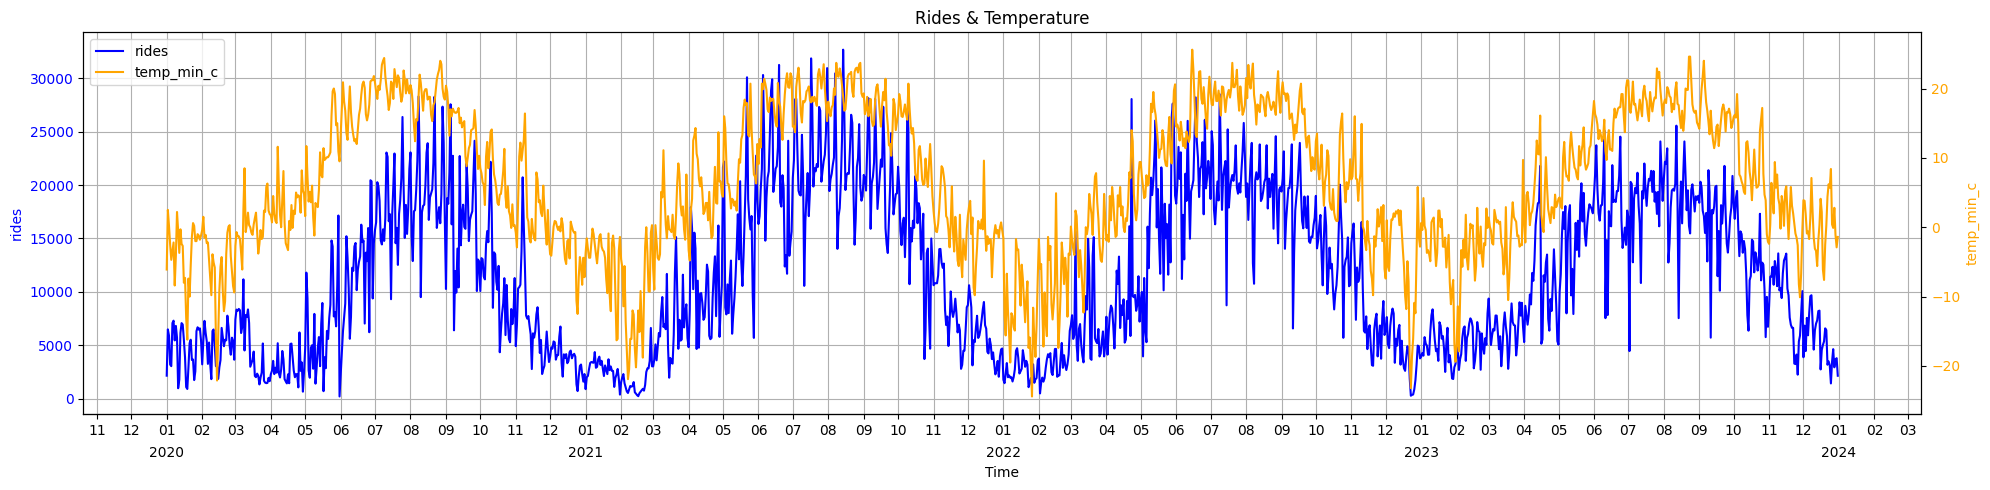

Correlation between rides and temperature: 82.01%


In [ ]:
compare_ts(rides_by_date_real["date"],rides_by_date_real["rides"],rides_by_date_real["temp_min_c"],"rides","temp_min_c","Rides & Temperature")
print(f"Correlation between rides and temperature: {round(rides_by_date_real['rides'].corr(rides_by_date_real['temp_min_c'])*100, 2)}%")

In 2020, weather and rides seem less close compared to 2021 onwards. There might be a covid effect in 2020. We visualize it through a clear moving average.

### Moving average

Monthly

Correlation between rides and temperature: 82.01%


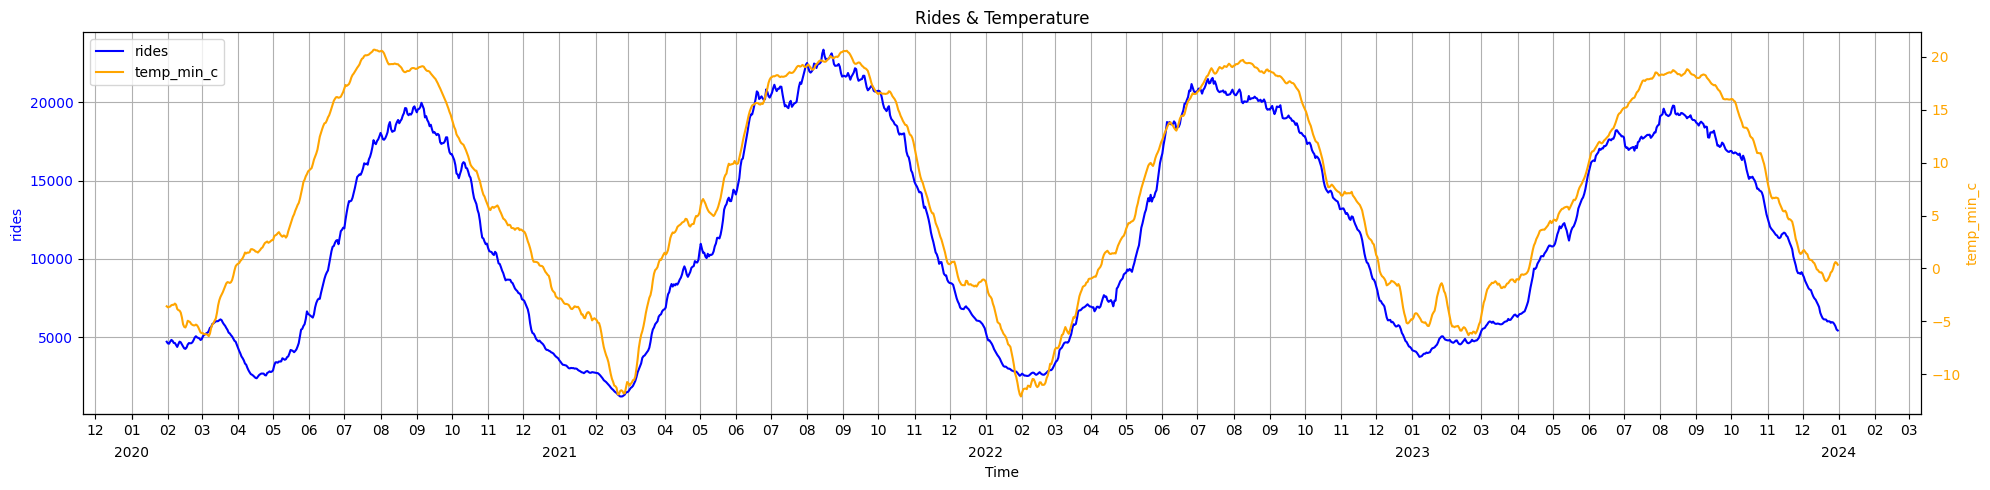

In [ ]:
compare_ts(rides_by_date_real["date"][30:],
           rides_by_date_real["rides"].rolling(window=30, min_periods=1).mean()[30:],
           rides_by_date_real["temp_min_c"].rolling(window=30, min_periods=1).mean()[30:],
           "rides","temp_min_c","Rides & Temperature")
# print(f"Correlation between rides and temperature: {round(rides_by_date_real['rides'].corr(rides_by_date_real['temperature_mean_c'])*100, 2)}%")

## Real Temperature vs Forecasted Temperature

Mean Absolute Error (MAE): 0.90
Mean Squared Error (MSE): 1.61
Mean Absolute Percentage Error (MAPE): 2747226640411095.50%
Symmetric Mean Absolute Percentage Error (sMAPE): 30.33%
R-squared (R²): 0.9845


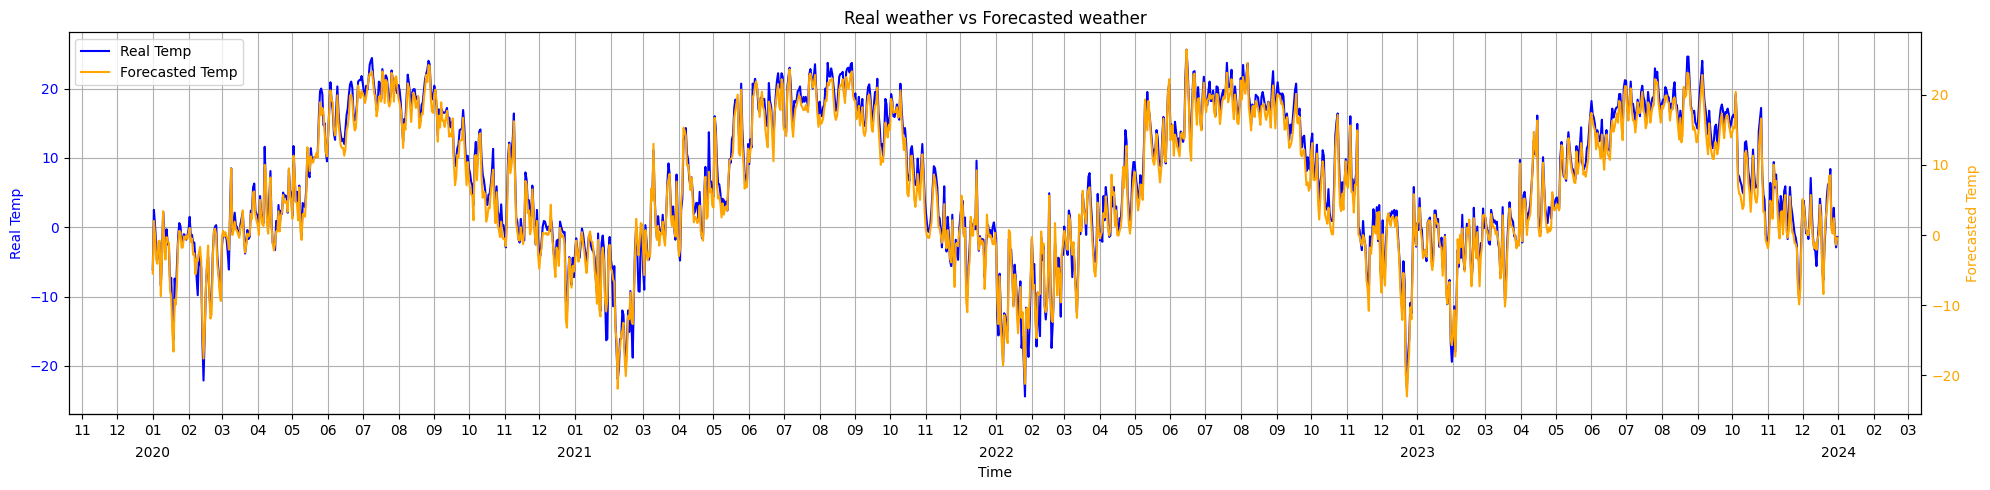

In [ ]:
# Calculate metrics
error_metrics(rides_by_date_real['temp_min_c'],rides_by_date_fore['temp_min_c'])
compare_ts(rides_by_date_real["date"],rides_by_date_real['temp_min_c'],rides_by_date_fore['temp_min_c'],"Real Temp","Forecasted Temp","Real weather vs Forecasted weather")

MAPE explodes because near 0  values. According to R square, the quality of forecasted weather is pretty good.

# Rain

## Rides vs Rain

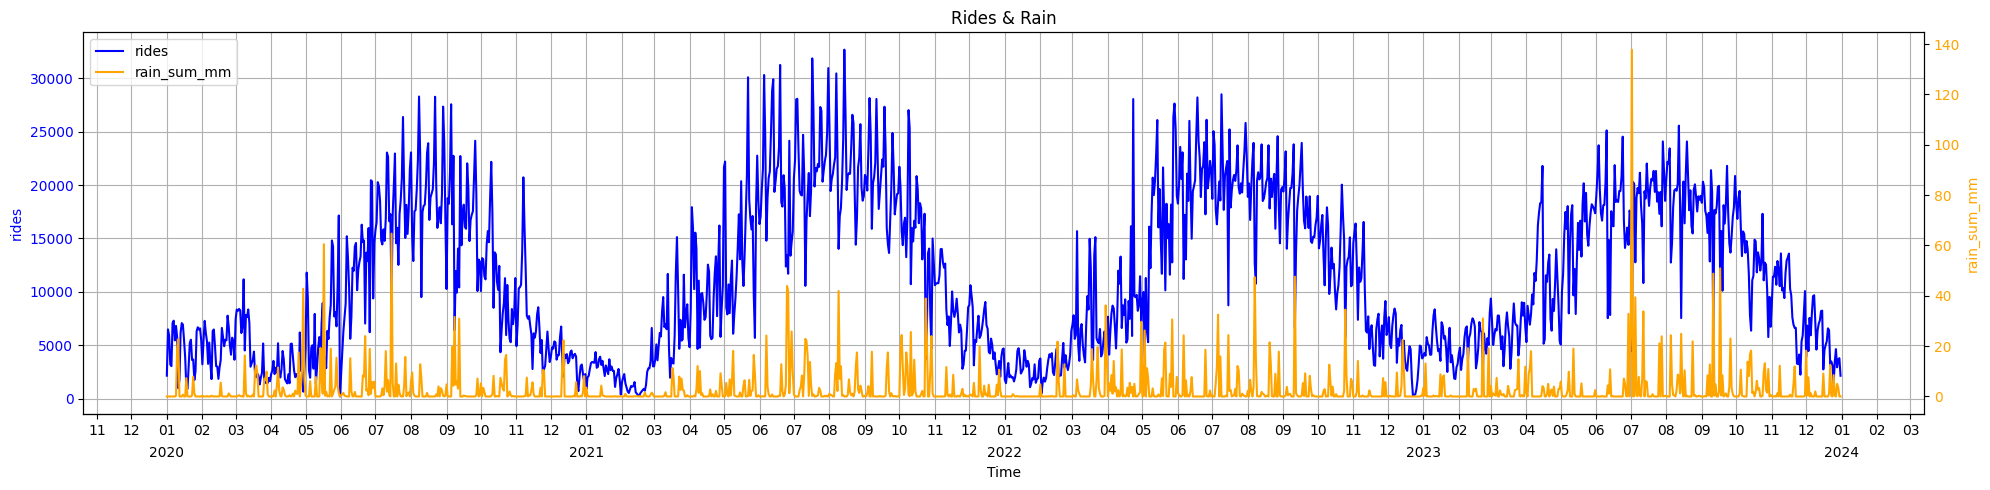

Correlation between rides and Rain: -7.34%


In [ ]:
compare_ts(rides_by_date_real["date"],rides_by_date_real["rides"],rides_by_date_real["rain_sum_mm"],"rides","rain_sum_mm","Rides & Rain")
print(f"Correlation between rides and Rain: {round(rides_by_date_real['rides'].corr(rides_by_date_real['rain_sum_mm'])*100, 2)}%")

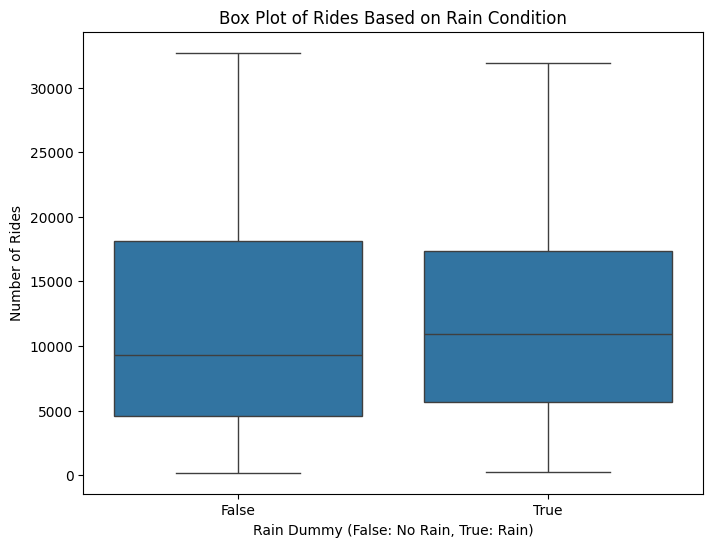

T-statistic: 1.1681, P-value: 0.2430


In [ ]:
rides_by_date_real["rain_dummy"] = (rides_by_date_real["rain_sum_mm"]>0)
plt.figure(figsize=(8, 6))
sns.boxplot(x='rain_dummy', y='rides', data=rides_by_date_real)

# Set labels and title
plt.xlabel("Rain Dummy (False: No Rain, True: Rain)")
plt.ylabel("Number of Rides")
plt.title("Box Plot of Rides Based on Rain Condition")

# Show the plot
plt.show()
from scipy import stats

# Separate the rides based on rain_dummy
rainy_rides = rides_by_date_real[rides_by_date_real['rain_dummy'] == True]['rides']
non_rainy_rides = rides_by_date_real[rides_by_date_real['rain_dummy'] == False]['rides']

# Perform independent t-test (assuming unequal variance)
t_stat, p_value = stats.ttest_ind(rainy_rides, non_rainy_rides, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

Means of rides are not statistically different between rainy days and non-rainy days.

## Heavy Rain & Moderate Rain

In [ ]:
rides_by_date_real[rides_by_date_real["rain_dummy"]==True]["rain_sum_mm"].quantile([0.75,0.5,0.25])

,rain_sum_mm
0.75,7.8
0.50,2.3
0.25,0.4


### Heavy Rain

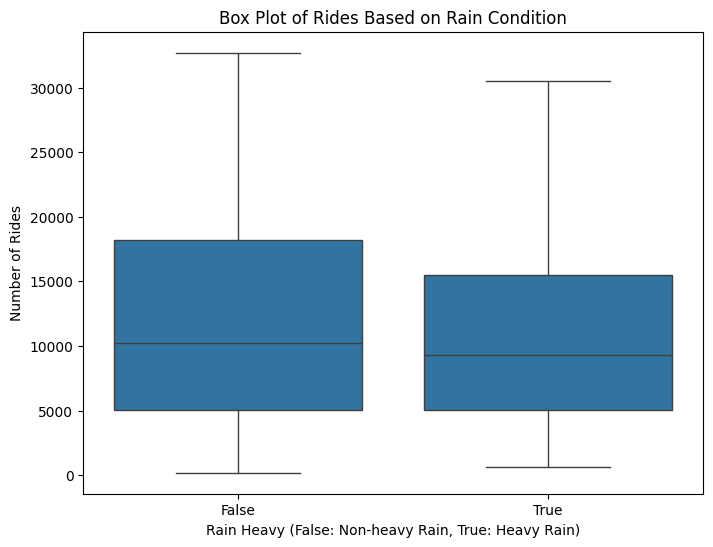

T-statistic: -2.7008, P-value: 0.0074
Rides in heavy rain 10221.300578034683
Rides in other days 11595.41135303266


In [ ]:
rides_by_date_real["rain_heavy"] = (rides_by_date_real["rain_sum_mm"]>=7.8)
plt.figure(figsize=(8, 6))
sns.boxplot(x='rain_heavy', y='rides', data=rides_by_date_real)

# Set labels and title
plt.xlabel("Rain Heavy (False: Non-heavy Rain, True: Heavy Rain)")
plt.ylabel("Number of Rides")
plt.title("Box Plot of Rides Based on Rain Condition")

# Show the plot
plt.show()
from scipy import stats

# Separate the rides based on rain_dummy
rainy_heavy_rides = rides_by_date_real[rides_by_date_real['rain_heavy'] == True]['rides']
non_heavy_rainy_rides = rides_by_date_real[rides_by_date_real['rain_heavy'] == False]['rides']

# Perform independent t-test (assuming unequal variance)
t_stat, p_value = stats.ttest_ind(rainy_heavy_rides, non_heavy_rainy_rides, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
print("Rides in heavy rain",rainy_heavy_rides.mean())
print("Rides in other days",non_heavy_rainy_rides.mean())

# Snow

## Rides vs Snow

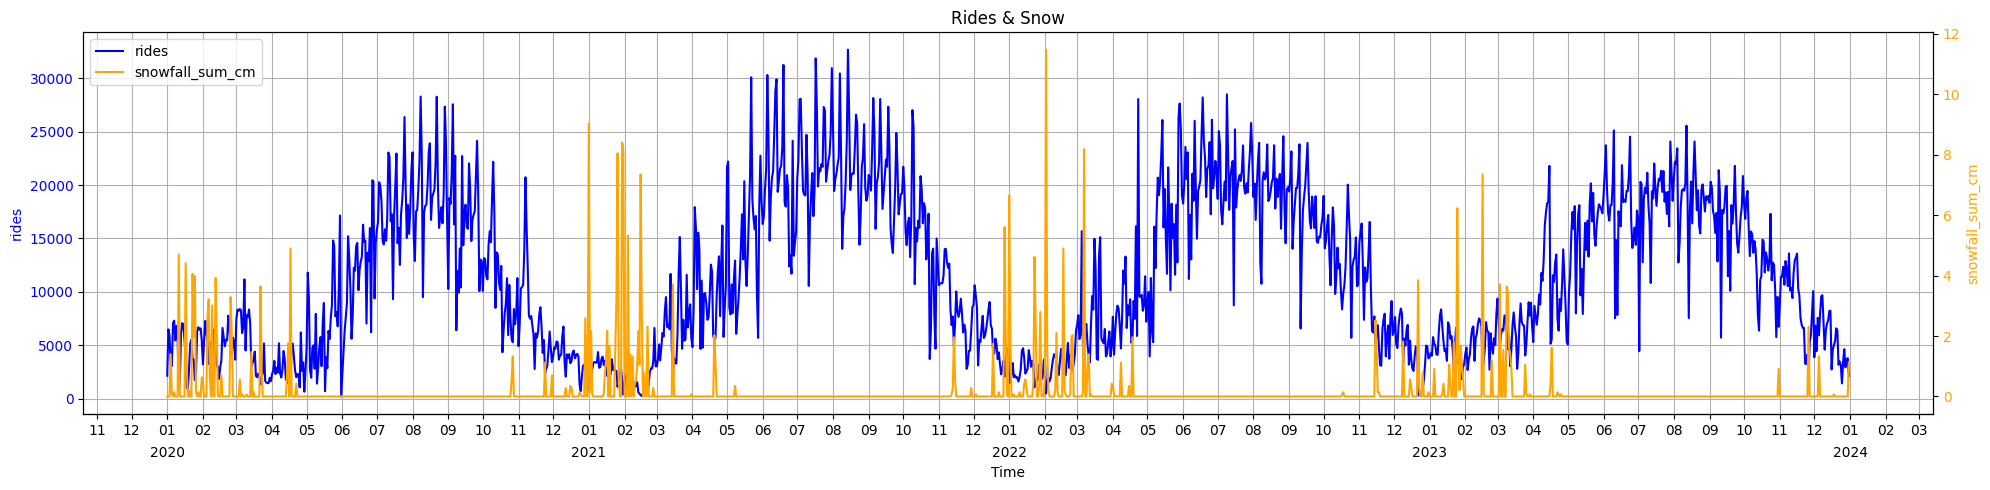

Correlation between rides and Snow: -26.41%


In [ ]:
compare_ts(rides_by_date_real["date"],rides_by_date_real["rides"],rides_by_date_real["snowfall_sum_cm"],"rides","snowfall_sum_cm","Rides & Snow")
print(f"Correlation between rides and Snow: {round(rides_by_date_real['rides'].corr(rides_by_date_real['snowfall_sum_cm'])*100, 2)}%")

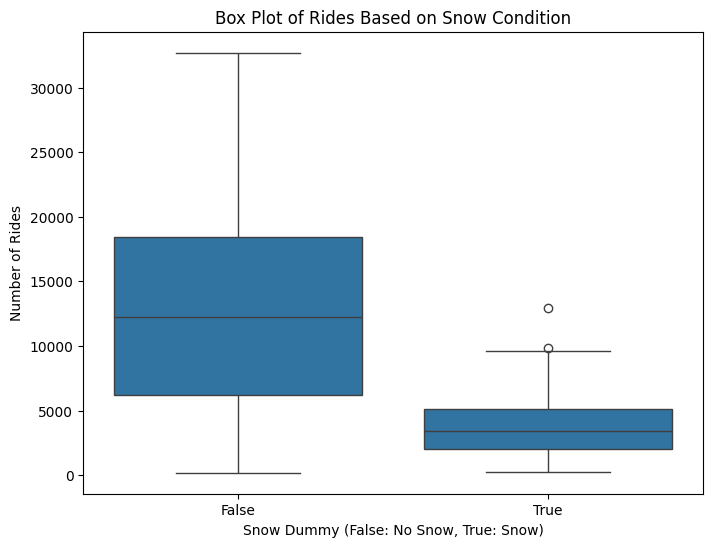

T-statistic: -33.4535, P-value: 0.0000


In [ ]:
rides_by_date_real["snow_dummy"] = (rides_by_date_real["snowfall_sum_cm"]>0)
plt.figure(figsize=(8, 6))
sns.boxplot(x='snow_dummy', y='rides', data=rides_by_date_real)

# Set labels and title
plt.xlabel("Snow Dummy (False: No Snow, True: Snow)")
plt.ylabel("Number of Rides")
plt.title("Box Plot of Rides Based on Snow Condition")

# Show the plot
plt.show()
from scipy import stats

# Separate the rides based on rain_dummy
rainy_rides = rides_by_date_real[rides_by_date_real['snow_dummy'] == True]['rides']
non_rainy_rides = rides_by_date_real[rides_by_date_real['snow_dummy'] == False]['rides']

# Perform independent t-test (assuming unequal variance)
t_stat, p_value = stats.ttest_ind(rainy_rides, non_rainy_rides, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

Means of rides are statistically different between snowy days and non-snowy days.

## Real Snow vs Forecasted Snow

Mean Absolute Error (MAE): 0.09
Mean Squared Error (MSE): 0.14
Mean Absolute Percentage Error (MAPE): 1058762626585397.62%
Symmetric Mean Absolute Percentage Error (sMAPE): 14.67%
R-squared (R²): 0.8168


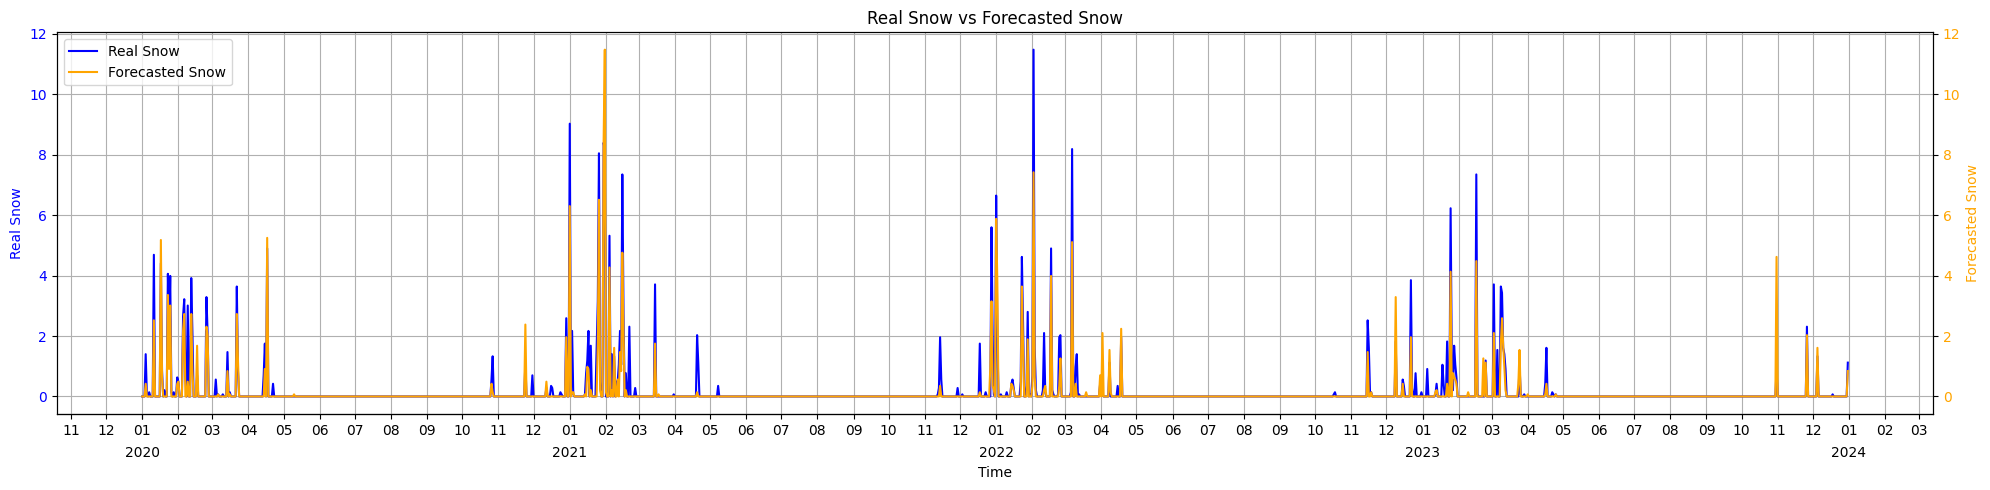

In [ ]:
# Calculate metrics
error_metrics(rides_by_date_real['snowfall_sum_cm'],rides_by_date_fore['snowfall_sum_cm'])
compare_ts(rides_by_date_real["date"],rides_by_date_real['snowfall_sum_cm'],rides_by_date_fore['snowfall_sum_cm'],"Real Snow","Forecasted Snow","Real Snow vs Forecasted Snow")

## Rides vs Log Snow

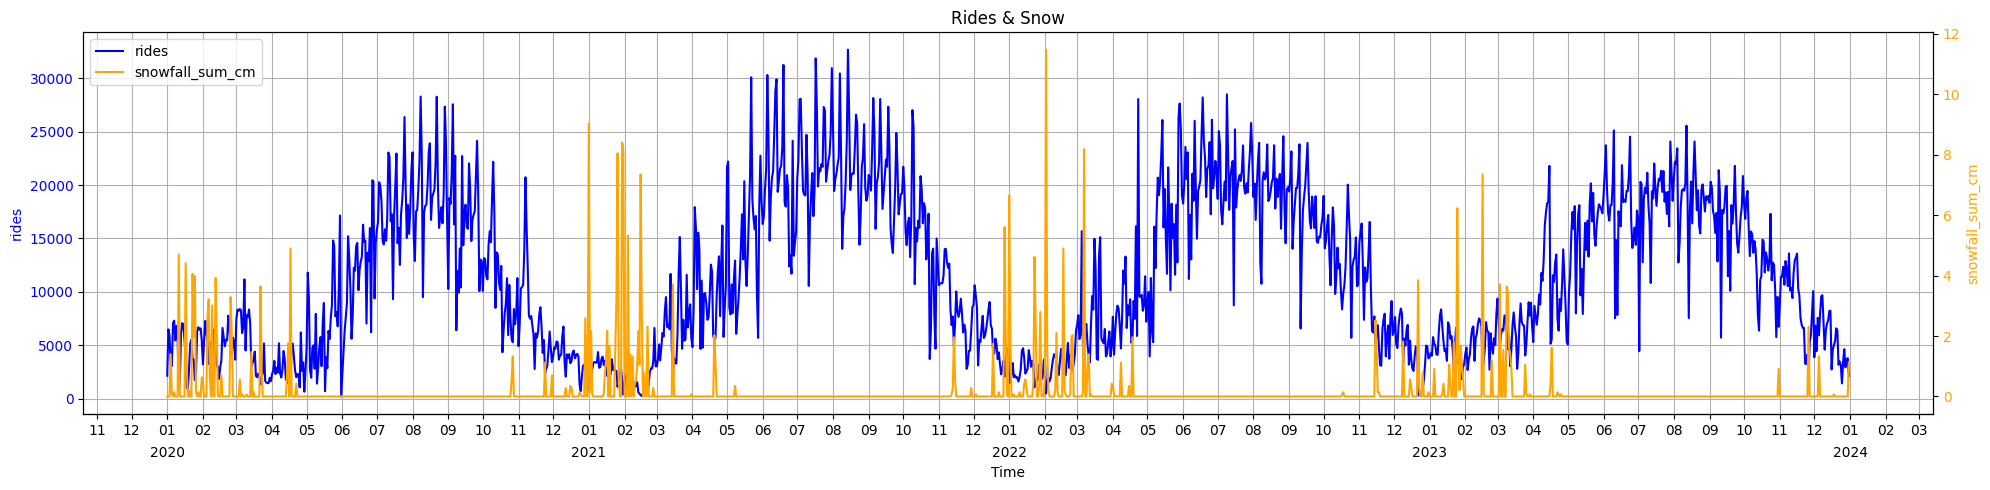

Correlation between rides and Log Snow: -32.11%


In [ ]:
compare_ts(rides_by_date_real["date"],rides_by_date_real["rides"],rides_by_date_real["snowfall_sum_cm"],"rides","snowfall_sum_cm","Rides & Snow")
print(f"Correlation between rides and Log Snow: {round(rides_by_date_real['rides'].corr(np.log(rides_by_date_real['snowfall_sum_cm']+1))*100, 2)}%")

The correlation between rides and snow strengthen after taking log.

# Wind

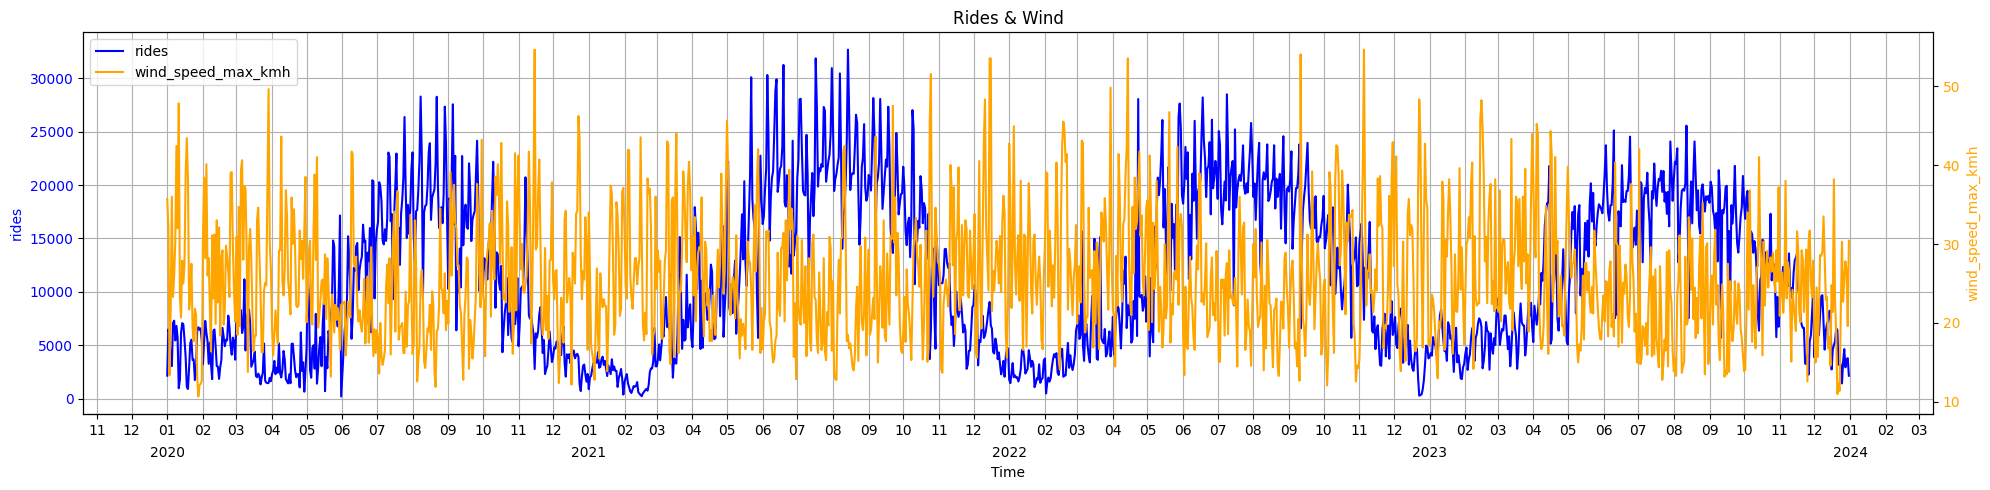

Correlation between rides and Wind: -28.42%


In [ ]:
compare_ts(rides_by_date_real["date"],rides_by_date_real["rides"],rides_by_date_real["wind_speed_max_kmh"],"rides","wind_speed_max_kmh","Rides & Wind")
print(f"Correlation between rides and Wind: {round(rides_by_date_real['rides'].corr(rides_by_date_real['wind_speed_max_kmh'])*100, 2)}%")

### Moving Average

Monthly

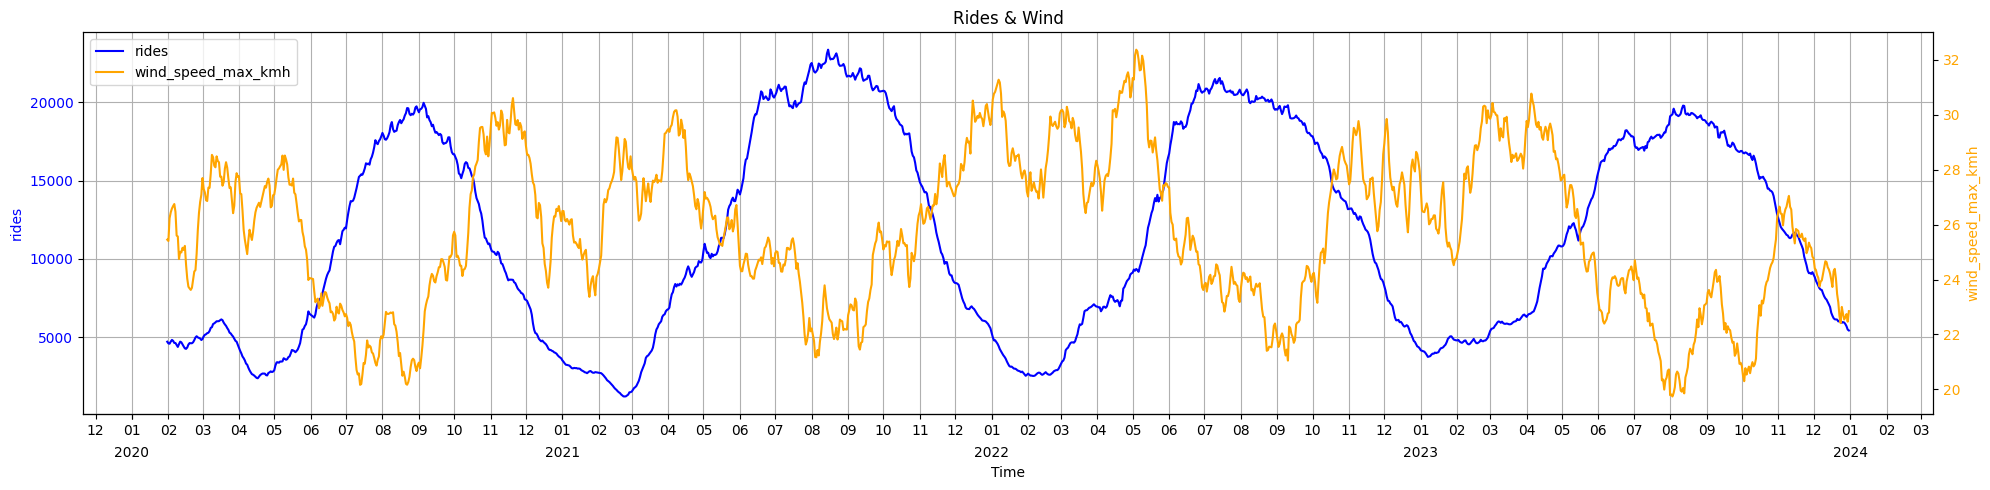

In [ ]:
compare_ts(rides_by_date_real["date"][30:],
           rides_by_date_real["rides"].rolling(window=30, min_periods=1).mean()[30:],
           rides_by_date_real["wind_speed_max_kmh"].rolling(window=30, min_periods=1).mean()[30:],
           "rides","wind_speed_max_kmh","Rides & Wind")

## Real Wind vs Forecasted Wind

Mean Absolute Error (MAE): 5.20
Mean Squared Error (MSE): 40.20
Mean Absolute Percentage Error (MAPE): 19.73%
Symmetric Mean Absolute Percentage Error (sMAPE): 22.39%
R-squared (R²): 0.3353


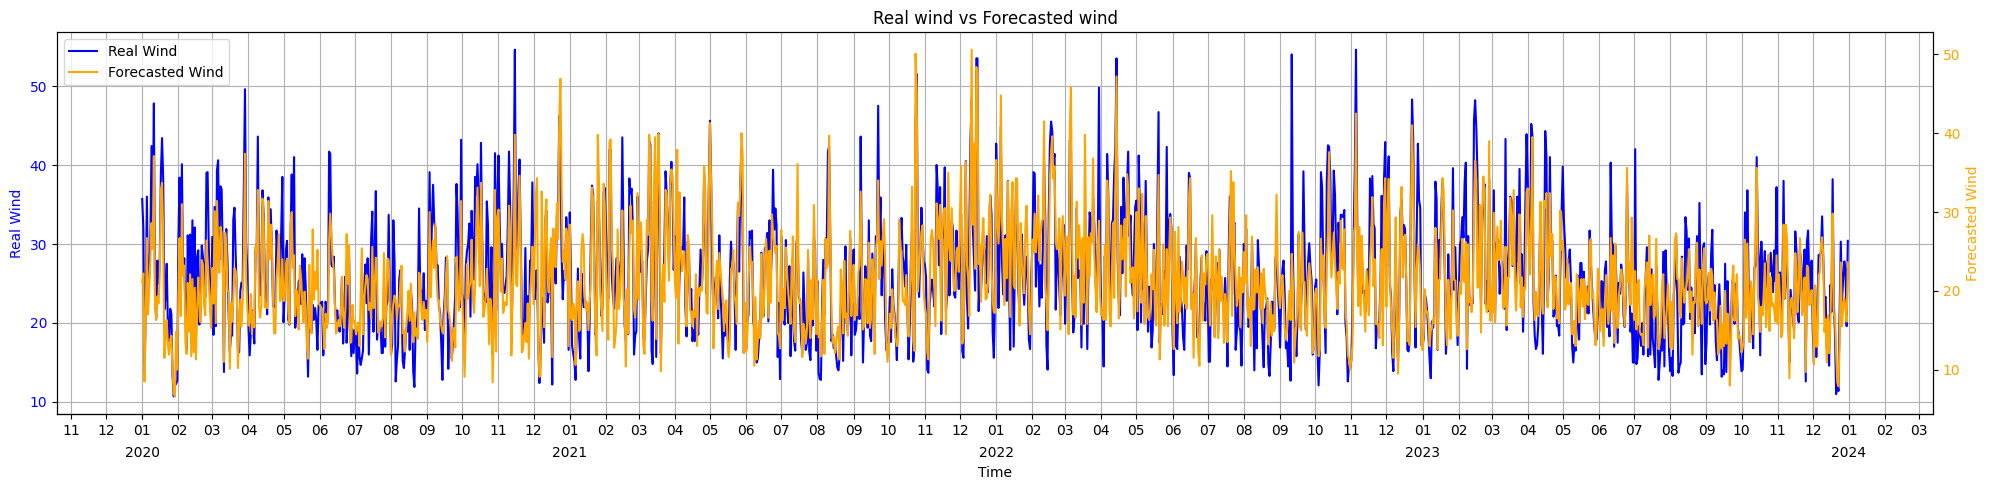

In [ ]:
# Calculate metrics
error_metrics(rides_by_date_real['wind_speed_max_kmh'],rides_by_date_fore['wind_speed_max_kmh'])
compare_ts(rides_by_date_real["date"],
           rides_by_date_real['wind_speed_max_kmh'],
           rides_by_date_fore['wind_speed_max_kmh'],
           "Real Wind","Forecasted Wind","Real wind vs Forecasted wind")

# Relationship between weather variables

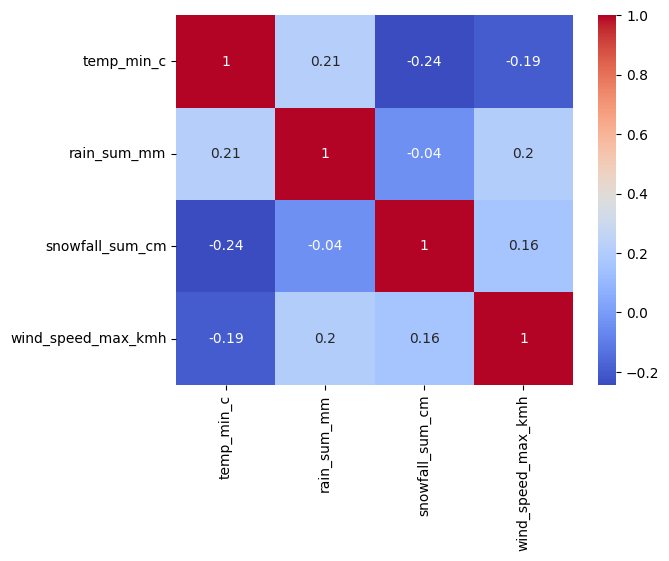

In [ ]:
rides_by_date_real.corr()
sns.heatmap(rides_by_date_real[["temp_min_c","rain_sum_mm","snowfall_sum_cm","wind_speed_max_kmh"]].corr(), annot=True, cmap='coolwarm')
plt.show()